In [40]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import ValueWarning

In [5]:
CAMINHO_RAIZ = os.getcwd()
caminho_dados = os.path.join(CAMINHO_RAIZ, "data", "dengue_pernambuco.xlsx")

In [6]:
dataset = pd.read_excel(caminho_dados)
dataset["semana"] = pd.to_datetime(dataset["semana"])
dataset.set_index("semana", inplace=True)

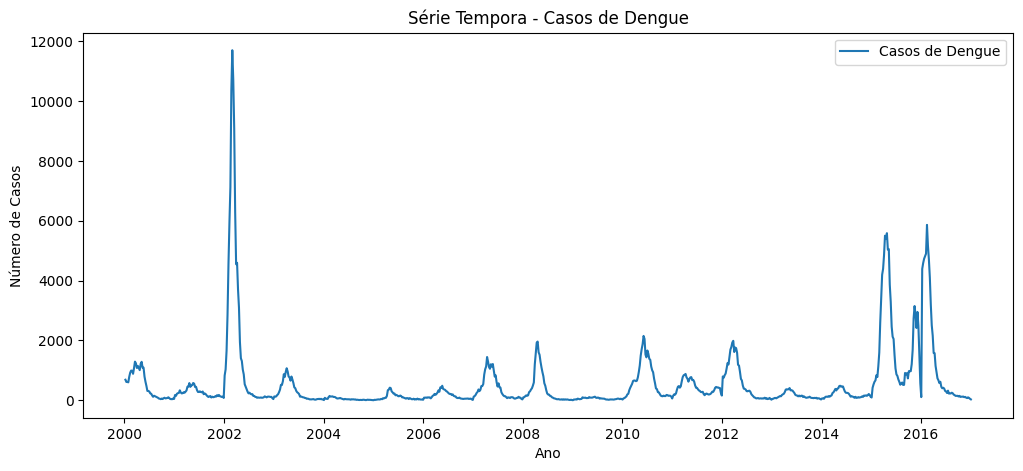

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(dataset.index, dataset["valor"], label="Casos de Dengue")
plt.title("Série Tempora - Casos de Dengue")
plt.xlabel("Ano")
plt.ylabel("Número de Casos")
plt.legend()
plt.show()

In [8]:
resultado_estacionariedade = adfuller(dataset["valor"])
print("Estatística ADF:", resultado_estacionariedade[0])
print("p-valor:", resultado_estacionariedade[1])

Estatística ADF: -5.663070483050537
p-valor: 9.28398959516521e-07


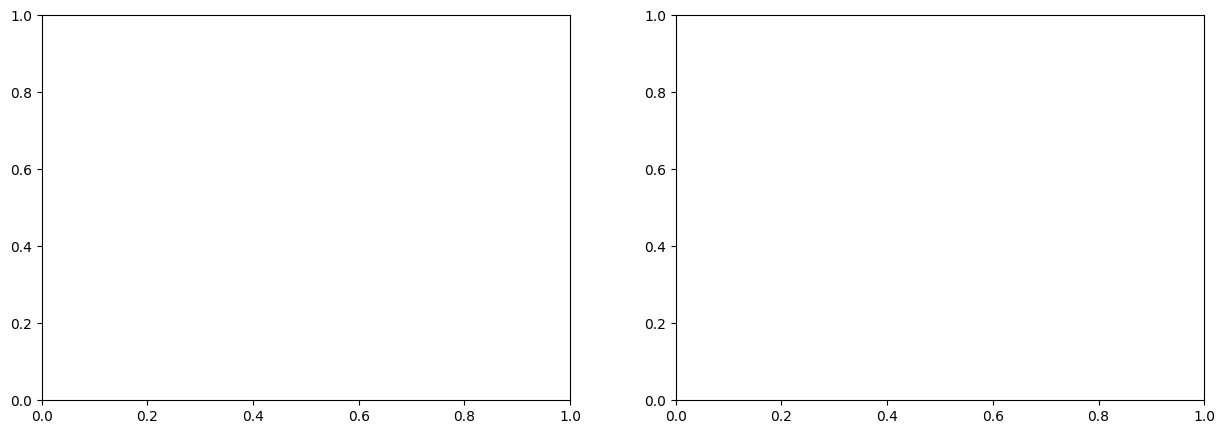

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

In [37]:
best_results = []
p_range = range(0, 4)
d = 0

q_range = range(0, 4)

P_range = range(0, 4)
D = 1
Q_range = range(0, 4)

s=52

In [21]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
serie = dataset["valor"].astype(float)
for p in p_range:
    for q in q_range:
        for P in P_range:
            for Q in Q_range:
                try:
                    order = (p, d, q)
                    seasonal_order = (P, D, Q, s)
                    model = SARIMAX(serie,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
                    res = model.fit(disp=False, method="lbfgs")  # 'lbfgs' é otimizador; outros são possíveis
                    best_results.append((order, seasonal_order, res.aic, res.bic, res))
                    print(f"OK order={order} seasonal={seasonal_order} AIC={res.aic:.1f} BIC={res.bic:.1f}")
                except Exception as e:
                    print(f"falha order={(p,d,q)} seasonal={(P,D,Q,s)} -> {str(e)}")



OK order=(0, 0, 0) seasonal=(0, 1, 0, 52) AIC=14600.0 BIC=14604.7
OK order=(0, 0, 0) seasonal=(0, 1, 1, 52) AIC=13330.3 BIC=13339.6


In [23]:
# ordenar pelos melhores AIC
best_results_sorted = sorted(best_results, key=lambda x: x[2])
best_p, best_q, best_aic, best_bic, best_model = best_results_sorted[0]

print("Melhor modelo por AIC:", f"p={best_p}, d={d}, q={best_q}, AIC={best_aic:.2f}, BIC={best_bic:.2f}")


Melhor modelo por AIC: p=1, d=1, q=3, AIC=12346.41, BIC=12370.34


In [24]:
# 'best_model' já é o objeto resultante (.fit()) do melhor ajuste
print(best_model.summary())  # resumo estatístico do ajuste

                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                  887
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -6168.203
Date:                Tue, 30 Sep 2025   AIC                          12346.406
Time:                        20:02:21   BIC                          12370.339
Sample:                    01-08-2000   HQIC                         12355.556
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8222      0.021    -38.393      0.000      -0.864      -0.780
ma.L1          1.3288      0.023     58.103      0.000       1.284       1.374
ma.L2          0.6865      0.019     36.900      0.0

In [27]:
residuos = best_model.resid

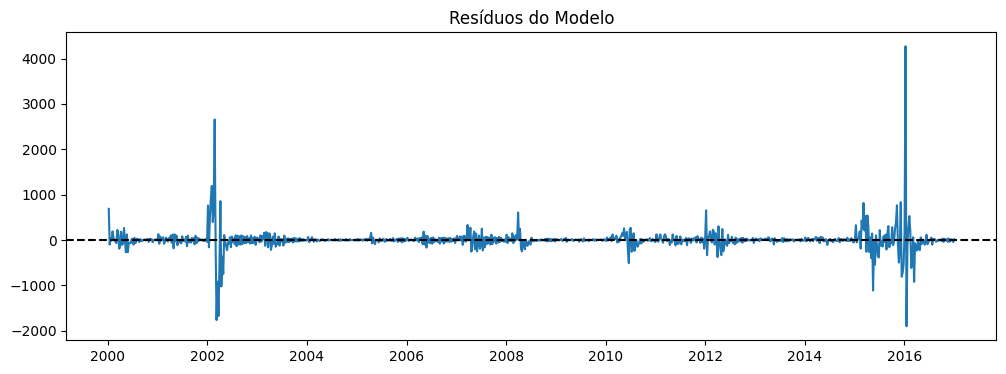

In [28]:
plt.figure(figsize=(12,4))
plt.plot(residuos)
plt.title("Resíduos do Modelo")
plt.axhline(0, color="black", linestyle="--")
plt.show()

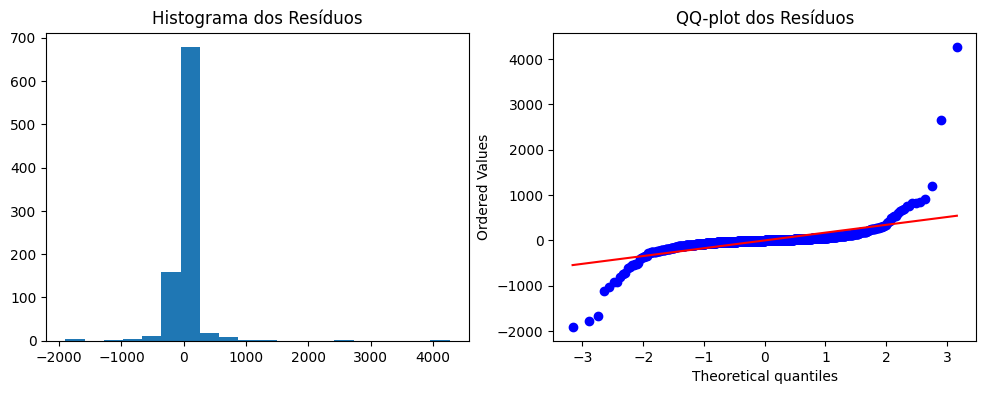

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(residuos, bins=20)
plt.title("Histograma dos Resíduos")
plt.subplot(1,2,2)
stats.probplot(residuos, dist="norm", plot=plt)  # QQ-plot
plt.title("QQ-plot dos Resíduos")
plt.show()

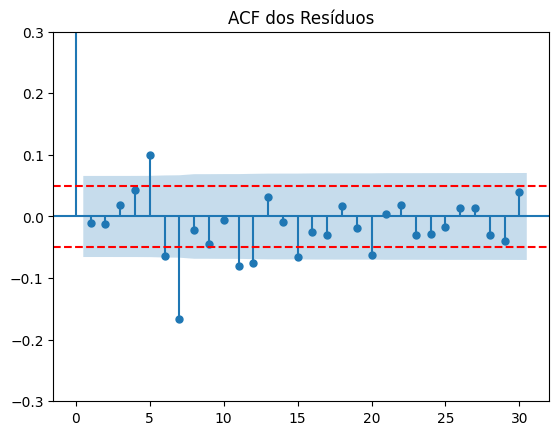

In [32]:
plot_acf(residuos, lags=30)
plt.title("ACF dos Resíduos")

plt.ylim(-0.3, 0.3)

plt.axhline(y=0.05, color='red', linestyle='--')
plt.axhline(y=-0.05, color='red', linestyle='--')

plt.show()

In [31]:
lb_test = acorr_ljungbox(residuos, lags=[10, 15, 20], return_df=True)
print("Ljung-Box test (estatística e p-valor por lag):")
print(lb_test)

Ljung-Box test (estatística e p-valor por lag):
      lb_stat     lb_pvalue
10  41.915371  7.763182e-06
15  57.820111  5.953437e-07
20  63.246499  2.213829e-06
